In [139]:
from epitope_data import EpitopeDataVdjDB
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")
plt.style.use('ggplot')

In [21]:
# here I just add a row for TRB with NLV
data = pd.read_csv('Gee2018_VDJdb.csv')

In [23]:
rows = {'antigen.epitope': 'NLVPMVATV', 'cdr3.beta': 'CASSLAPGATNEKLFF', 'mhc.a': 'HLA-A*02:01', 
        'species': 'HomoSapiens'}

In [24]:
data.dropna(subset=['cdr3.alpha', 'cdr3.beta']).append(rows, ignore_index=True).to_csv('added_trb_nlv.csv', 
                                                                                       index=False)

In [25]:
# alpha chain
chain = 'TRA'
duplicates_alpha = EpitopeDataVdjDB(chain=chain, folder='.', file='Gee2018_VDJdb.csv', duplicate=True, 
                                    prediction_path=f'prediction_duplicates_Gee2018_VDJdb_{chain}.csv', 
                                    predict=True, duplicate_name='Gee2018_VDJdb')

(28, 3)


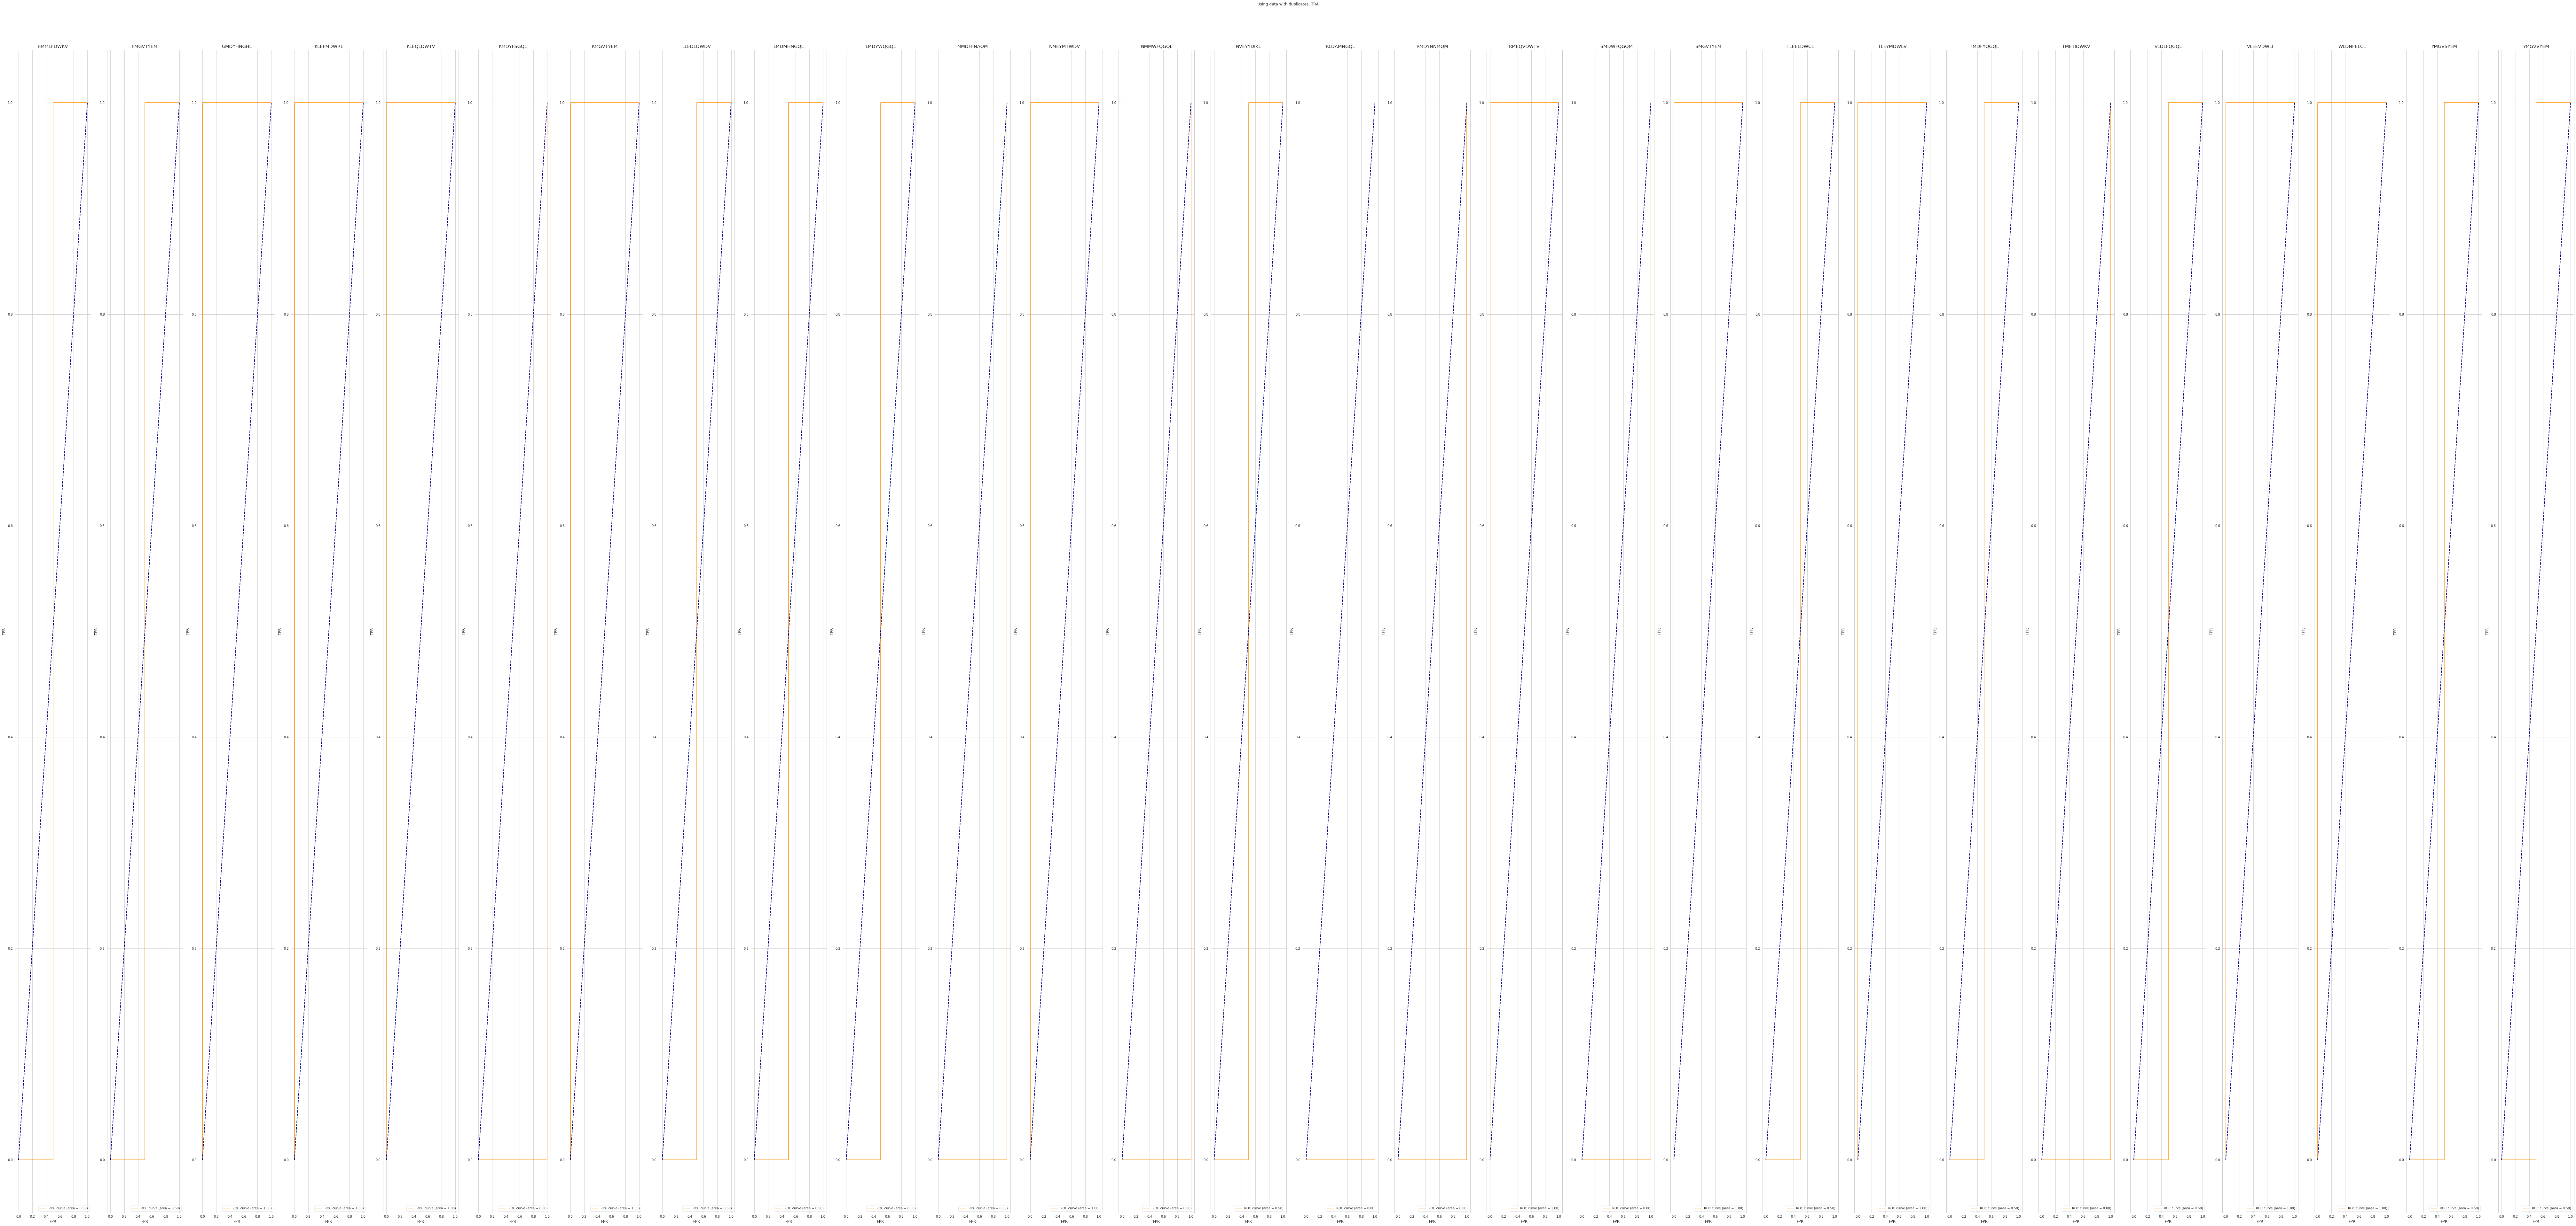

In [26]:
duplicates_alpha.roc()

In [27]:
tra_data = duplicates_alpha.data

In [28]:
# beta chain
chain = 'TRB'
duplicates_beta = EpitopeDataVdjDB(chain=chain, folder='.', file='added_trb_nlv.csv', duplicate=True, 
                                   prediction_path=f'prediction_duplicates_added_trb_nlv_{chain}.csv', 
                                   predict=True, duplicate_name='added_trb_nlv')

(34, 3)


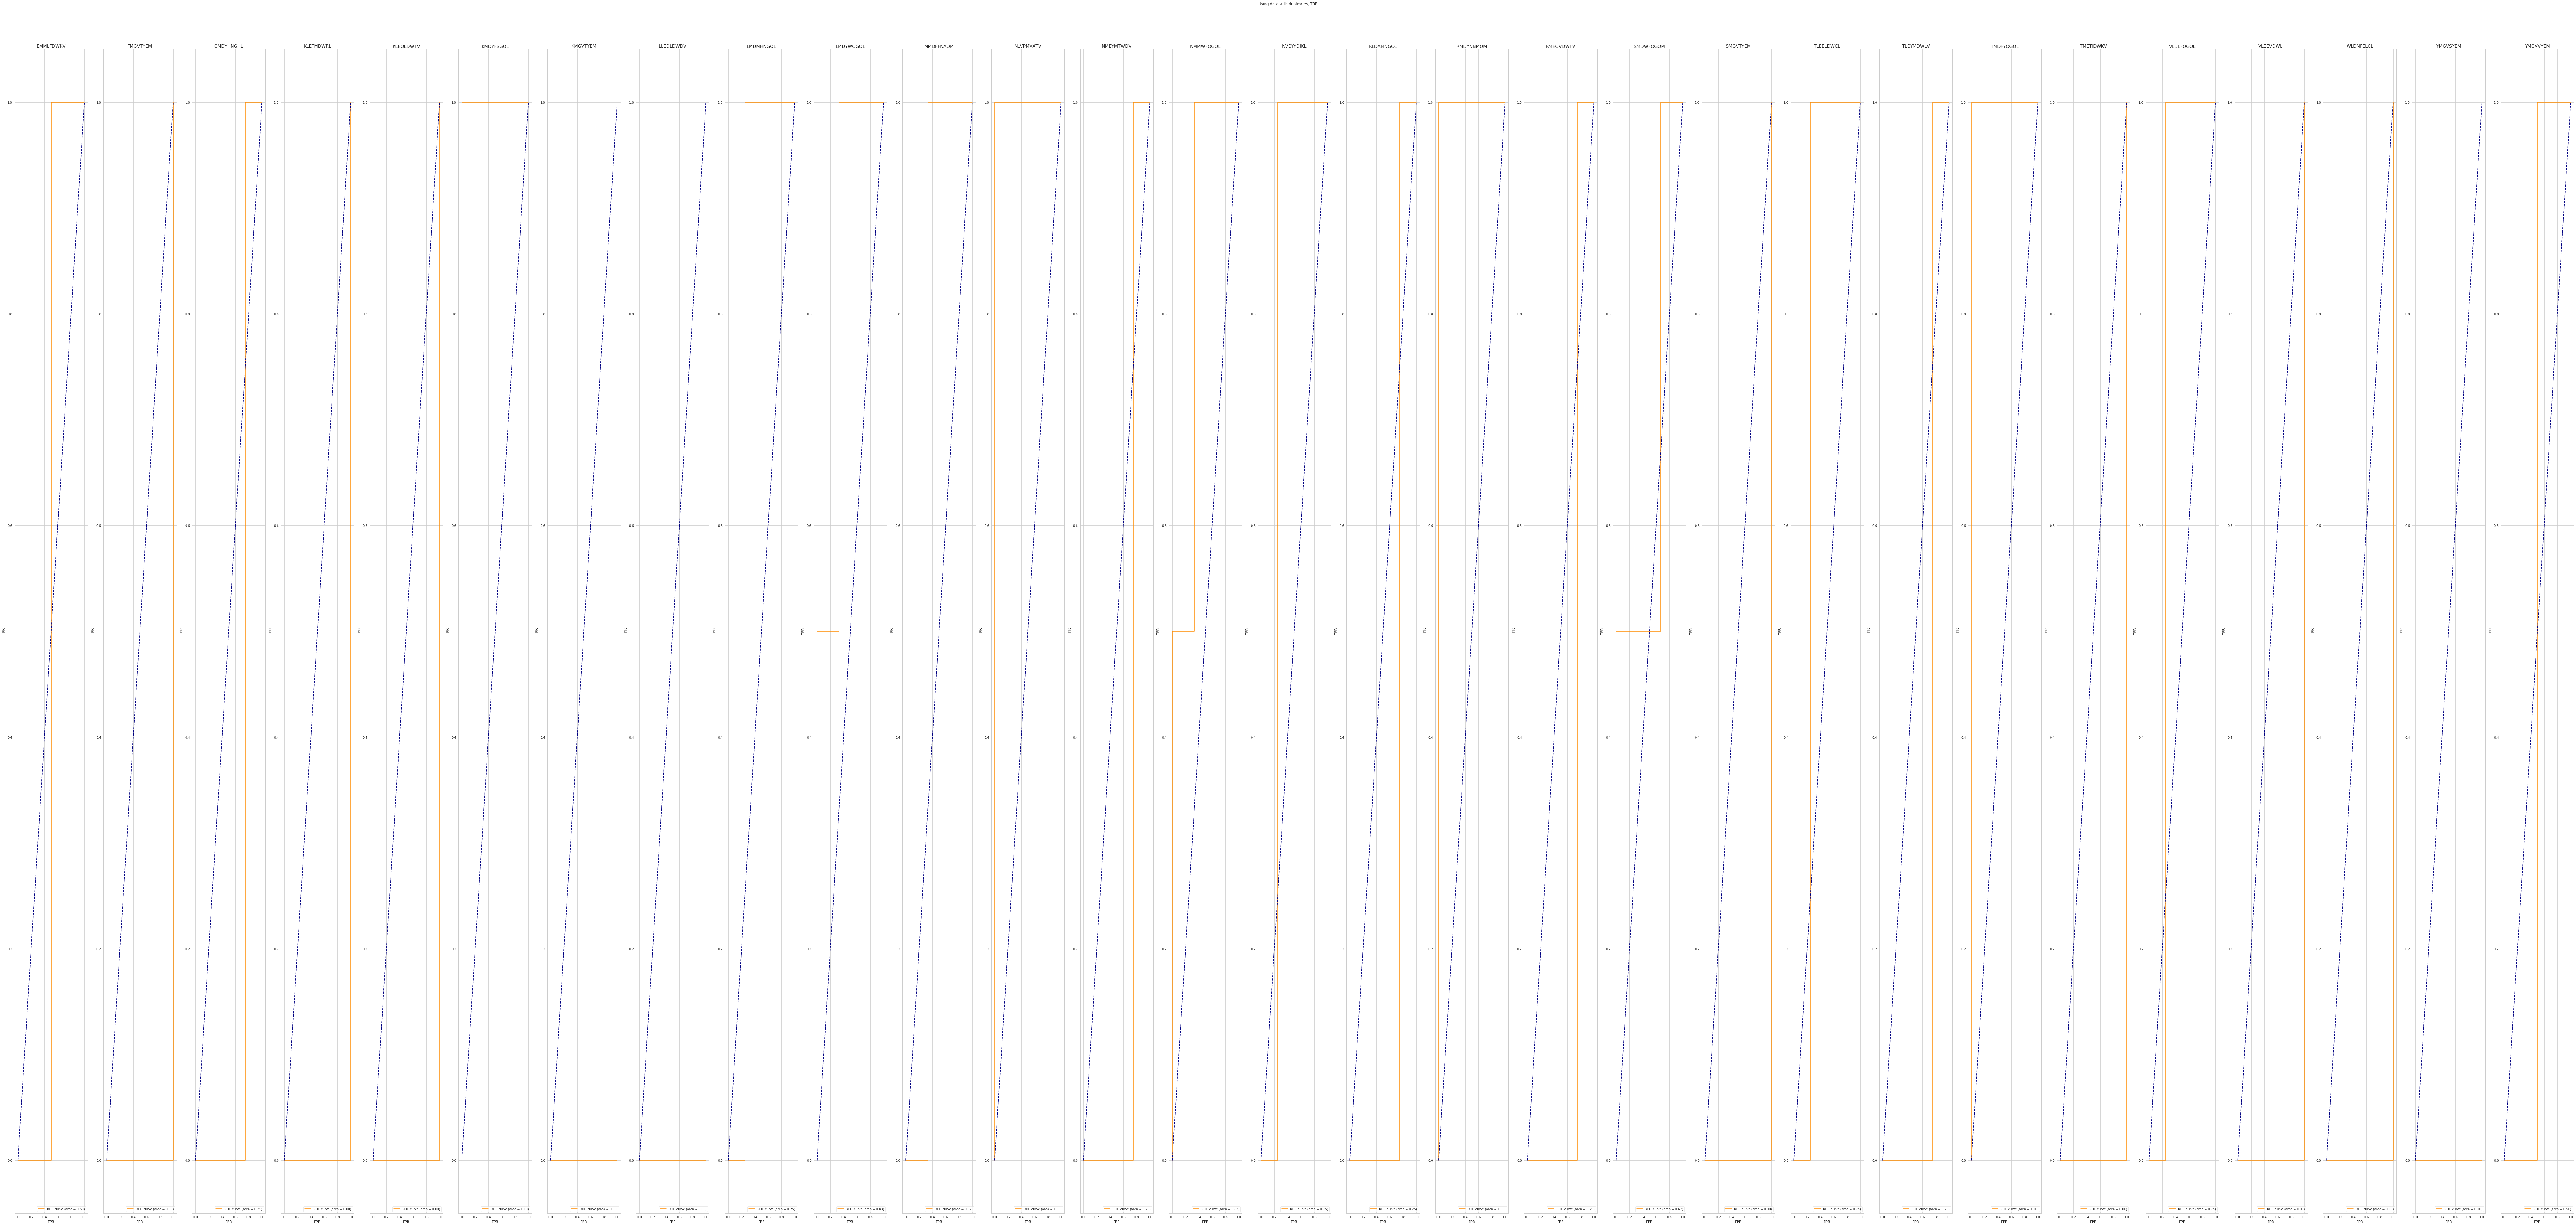

In [29]:
duplicates.roc()

In [30]:
trb_data = duplicates_beta.data

In [6]:
nlv_data = trb_data.loc[trb_data.Antigen == 'NLVPMVATV']

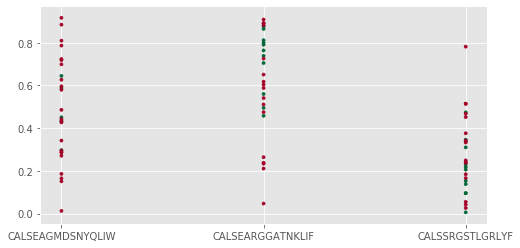

In [45]:
plt.figure(figsize=(8, 4))
plt.scatter(tra_data.CDR3, tra_data.Rank, c=tra_data.label, marker='o', s=10, cmap=cm.RdYlGn)

Text(0.5, 1.0, 'pMTnet results for TRA')

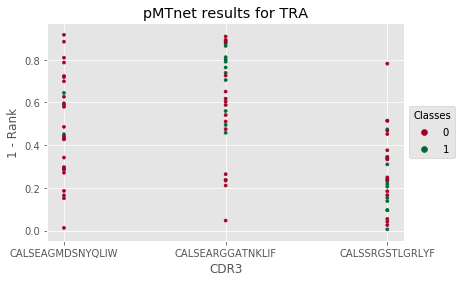

In [55]:
fig, ax = plt.subplots(figsize=(8, 4))
scatter = ax.scatter(tra_data.CDR3, tra_data.Rank, c=tra_data.label, marker='o', s=10, cmap=cm.RdYlGn)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
legend1 = ax.legend(*scatter.legend_elements(),
                    loc='center left', bbox_to_anchor=(1, 0.5), title="Classes")
ax.add_artist(legend1)
ax.set_xlabel('CDR3')
ax.set_ylabel('1 - Rank')
ax.set_title('pMTnet results for TRA')

Text(0.5, 1.0, 'pMTnet results for TRB')

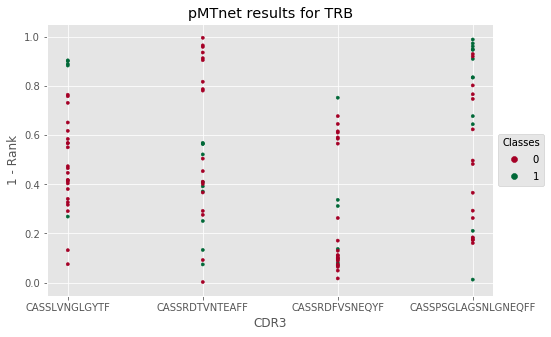

In [56]:
fig, ax = plt.subplots(figsize=(10, 5))
scatter = ax.scatter(trb_data.CDR3, trb_data.Rank, c=trb_data.label, marker='o', s=10, cmap=cm.RdYlGn)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
legend1 = ax.legend(*scatter.legend_elements(),
                    loc='center left', bbox_to_anchor=(1, 0.5), title="Classes")
ax.add_artist(legend1)
ax.set_xlabel('CDR3')
ax.set_ylabel('1 - Rank')
ax.set_title('pMTnet results for TRB')

In [31]:
tra_data['Label'] = tra_data.label.apply(lambda x: 'Real' if x == 1 else 'Substituted')
trb_data['Label'] = trb_data.label.apply(lambda x: 'Real' if x == 1 else 'Substituted')

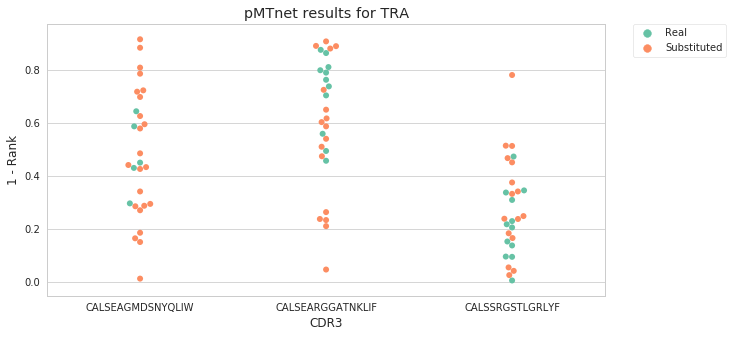

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.swarmplot(x="CDR3", y="Rank", hue='Label', data=tra_data, size=6, 
                   palette=sns.color_palette("Set2", 10))
# ax = sns.boxplot(x="day", y="total_bill", data=tips,
#         showcaps=False,boxprops={'facecolor':'None'},
#         showfliers=False,whiskerprops={'linewidth':0})
ax.set_ylabel('1 - Rank')
ax.set_title('pMTnet results for TRA')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

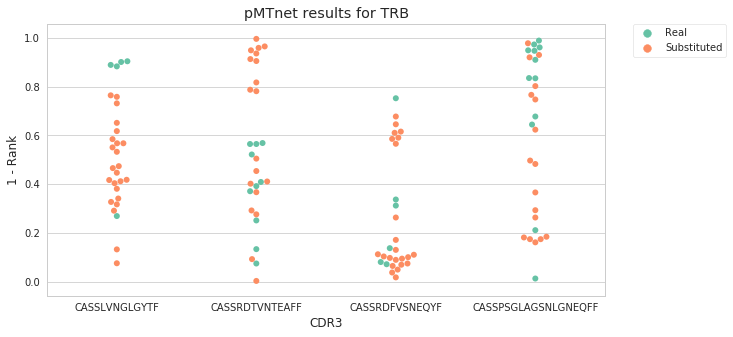

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.swarmplot(x="CDR3", y="Rank", hue='Label', 
                   data=trb_data.loc[trb_data.CDR3 != 'CASSLAPGATNEKLFF'], 
                                     size=6, palette=sns.color_palette("Set2"))
# ax = sns.boxplot(x="day", y="total_bill", data=tips,
#         showcaps=False,boxprops={'facecolor':'None'},
#         showfliers=False,whiskerprops={'linewidth':0})
ax.set_ylabel('1 - Rank')
ax.set_title('pMTnet results for TRB')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


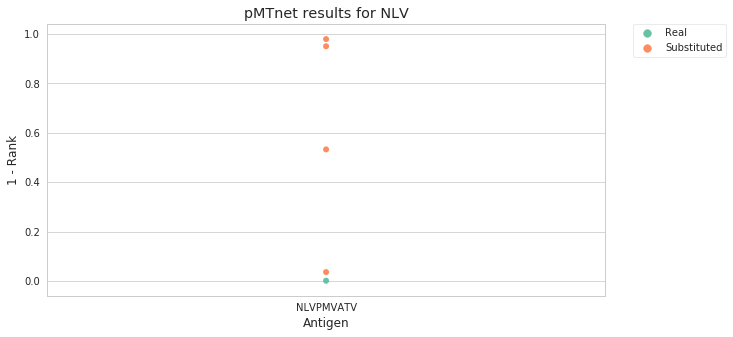

In [35]:
nlv_data['Label'] = nlv_data.label.apply(lambda x: 'Real' if x == 1 else 'Substituted')
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.swarmplot(x="Antigen", y="Rank", hue='Label', data=nlv_data, size=6, palette=sns.color_palette("Set2"))
# ax = sns.boxplot(x="day", y="total_bill", data=tips,
#         showcaps=False,boxprops={'facecolor':'None'},
#         showfliers=False,whiskerprops={'linewidth':0})
ax.set_ylabel('1 - Rank')
ax.set_title('pMTnet results for NLV')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)